# LTSF-Linear family
- Linear : one linear layer
- DLinear : Decomposition Linear -> trend와 seasonality 패턴을 핸들링
- NLinear : 정규화된 Linear로서 train-test set 분포 변화를 다룬다. 

In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device} is available.')

cuda is available.


In [3]:
config = {
    'batch_size': 32, # 일반적으로 32, 64 크기의 mini-batch가 성능에는 가장 좋다고 알려져 있다.
    'epoch': 50, # 이건 어느정도 해야하지
    'learning_rate' : 1e-2,
    'seq_len': 72, # look_back_window_size
    # 'label_len':2, # 이건 뭘까
    'pred_len': 24, # forecasting step인거같고
    'individual' : False,
    'enc_in':0 # feature column 개수?
}

# dlinear_size = [config['seq_len'], config['label_len'], config['pred_len']]


In [4]:
# torch를 사용할 때 seed 고정
def seed_everything(seed: int = 311):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # type: ignore
    torch.backends.cudnn.deterministic = True # type : ignore
    torch.backends.cudnn.benchmark = True # type:ignore


seed_everything()

# 데이터 불러오기 & 전처리
- 일단 환율만

In [5]:
import FinanceDataReader as fdr


df = fdr.DataReader('USD/KRW') # 모든 일자 가져오기
df = df.interpolate() # 결측치 채우기
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df 


,Date,Close
0,2003-12-01,1198.400024
1,2003-12-02,1195.000000
2,2003-12-03,1192.500000
3,2003-12-04,1190.099976
4,2003-12-05,1184.699951
...,...,...
5043,2023-03-30,1307.130005
5044,2023-03-31,1296.500000
5045,2023-04-03,1305.479980
5046,2023-04-04,1308.050049


In [6]:
df.head(5)

,Date,Close
0,2003-12-01,1198.400024
1,2003-12-02,1195.000000
2,2003-12-03,1192.500000
3,2003-12-04,1190.099976
4,2003-12-05,1184.699951


### DLinear
- DLinear : Autoformer와 FEDformer에서 사용되는 시계열 분해 방식을 선형 레이어와 결합한 모델.
1) 먼저 이동 평균값을 만들고 이를 제거하여 각각 학습하기 위해 추세와 주기성 데이터로 분해.
2) 그런 다음 각 구성 요소에 단일 선형 레이어를 적용하여 학습하고 두 개를 합산하여 최종 예측을 계산
3) Dlinear는 시계열 데이터의 명확한 추세와 주기성이 있을 때 바닐라 선형 모델보다 더 나은 성능을 가질 수 있다.

In [8]:
class moving_avg(nn.Module):
    '''
    Moving average block to highlight the trend of time series
    '''
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size = kernel_size, stride = stride, padding = 0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size -1) //2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1)) 
        x = x.permute(0,2,1) # 차원 순서바꾸기
        return x
    

class series_decomp(nn.Module):
    '''
    Series decomposition block
    '''
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        
        return res, moving_mean
    

class DLinear(nn.Module):
    """
    DLinear model
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']

        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size) # 리턴값이 두개인데..
        self.individual = configs['individual'] # individual
        self.channels = configs['enc_in'] # feature_size 

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList() # 리스트 초기화 선언 같은거
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels): # feature_size 만큼 -> 컬럼 개수만큼
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))


    def forward(self, x):
        # x: [Batch, Input, Length, Channel]
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len], dtype=trend_init.dtype).to(trend_init.device)
            
            for i in range(self.channels):
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:,i,:])
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)
            
        x= seasonal_output + trend_output
        return x.permute(0, 2, 1)


### Dataset 정의

In [9]:
# sliding window
def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1): # 0 ~ 
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1) # [[idx ~ idx + window size]]만큼 x data 배열 생성
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values # 엥 여러개 예측인가?? 미래시점t0 ~ 미래시점t forecasting_size만큼)
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)


class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [55]:
data = df.set_index('Date')
data.rename(columns = {'Close' : 'exchange_rate'}, inplace=True)

# 스케일링
scaler = MinMaxScaler()
data[['exchange_rate']] = scaler.fit_transform(data[['exchange_rate']])


data.reset_index(inplace=True)



### Univariable ###
### 데이터셋 생성 ###
window_size = config['seq_len'] # 72
forcast_size = config['pred_len'] # 24
batch_size = config['batch_size'] # 32
targets = 'exchange_rate'
date = 'Date'


# train & test split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=311, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


# slicing window
train_x, train_y, train_date = time_slide_df(train_df, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df, window_size, forcast_size, date, targets)

train_ds = Data(train_x[:3000], train_y[:3000])
valid_ds = Data(train_x[3000:], train_y[3000:])
test_ds = Data(test_x, test_y)


# DataLoader
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size = train_x[3000:].shape[0], shuffle=False)
test_dl = DataLoader(test_ds, batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []

test_pred_list = []
test_real_list = []

epoch = config['epoch'] # 50
DLinear_model = DLinear(config)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr = config['learning_rate'])
max_loss = 999999999


# 이 블록 안에서 예측값을 뽑아낼 수 있을 것 같다.
# 첫번째 값만 뽑아내도 될거같다.
for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data,target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval() # 검증모드
    with torch.no_grad():
        for data, target in valid_dl: # valid_dl에서 데이터 뽑아내기
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        for data, target in test_dl: # test_dl에서 데이터 뽑아내기
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)
            test_pred_list.append(output[0])
            test_real_list.append(target[0][0])

    if valid_loss < max_loss:
        torch.save(DLinear_model, './model/DLinear_model.pth')
        max_loss = valid_loss # max_loss 갱신
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())
    
    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|▍         | 2/50 [00:00<00:03, 14.29it/s]

valid_loss=0.007, test_los0.009, Model Save
epoch = 1, train_loss : 0.014, valid_loss : 0.007, test_loss : 0.009
valid_loss=0.005, test_los0.007, Model Save
epoch = 2, train_loss : 0.016, valid_loss : 0.005, test_loss : 0.007
valid_loss=0.005, test_los0.016, Model Save
epoch = 3, train_loss : 0.025, valid_loss : 0.005, test_loss : 0.016
epoch = 4, train_loss : 0.042, valid_loss : 0.013, test_loss : 0.046


 12%|█▏        | 6/50 [00:00<00:03, 14.58it/s]

epoch = 5, train_loss : 0.051, valid_loss : 0.020, test_loss : 0.054
epoch = 6, train_loss : 0.045, valid_loss : 0.017, test_loss : 0.041
epoch = 7, train_loss : 0.035, valid_loss : 0.012, test_loss : 0.027
epoch = 8, train_loss : 0.028, valid_loss : 0.009, test_loss : 0.020


 20%|██        | 10/50 [00:00<00:02, 14.61it/s]

epoch = 9, train_loss : 0.022, valid_loss : 0.007, test_loss : 0.016
epoch = 10, train_loss : 0.018, valid_loss : 0.006, test_loss : 0.013
epoch = 11, train_loss : 0.016, valid_loss : 0.005, test_loss : 0.011


 28%|██▊       | 14/50 [00:00<00:02, 14.75it/s]

valid_loss=0.004, test_los0.012, Model Save
epoch = 12, train_loss : 0.018, valid_loss : 0.004, test_loss : 0.012
epoch = 13, train_loss : 0.023, valid_loss : 0.006, test_loss : 0.017
epoch = 14, train_loss : 0.028, valid_loss : 0.008, test_loss : 0.023
epoch = 15, train_loss : 0.028, valid_loss : 0.010, test_loss : 0.023


 36%|███▌      | 18/50 [00:01<00:02, 14.87it/s]

epoch = 16, train_loss : 0.023, valid_loss : 0.007, test_loss : 0.015
valid_loss=0.004, test_los0.008, Model Save
epoch = 17, train_loss : 0.016, valid_loss : 0.004, test_loss : 0.008
valid_loss=0.003, test_los0.005, Model Save
epoch = 18, train_loss : 0.011, valid_loss : 0.003, test_loss : 0.005


 40%|████      | 20/50 [00:01<00:02, 14.82it/s]

valid_loss=0.002, test_los0.005, Model Save
epoch = 19, train_loss : 0.008, valid_loss : 0.002, test_loss : 0.005
valid_loss=0.002, test_los0.004, Model Save
epoch = 20, train_loss : 0.007, valid_loss : 0.002, test_loss : 0.004
epoch = 21, train_loss : 0.008, valid_loss : 0.002, test_loss : 0.005


 48%|████▊     | 24/50 [00:01<00:01, 14.84it/s]

epoch = 22, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.009
epoch = 23, train_loss : 0.019, valid_loss : 0.004, test_loss : 0.016
epoch = 24, train_loss : 0.029, valid_loss : 0.008, test_loss : 0.027
epoch = 25, train_loss : 0.038, valid_loss : 0.014, test_loss : 0.039


 56%|█████▌    | 28/50 [00:01<00:01, 14.87it/s]

epoch = 26, train_loss : 0.041, valid_loss : 0.016, test_loss : 0.039
epoch = 27, train_loss : 0.037, valid_loss : 0.012, test_loss : 0.027
epoch = 28, train_loss : 0.034, valid_loss : 0.009, test_loss : 0.021
epoch = 29, train_loss : 0.030, valid_loss : 0.008, test_loss : 0.018


 64%|██████▍   | 32/50 [00:02<00:01, 14.98it/s]

epoch = 30, train_loss : 0.024, valid_loss : 0.007, test_loss : 0.013
epoch = 31, train_loss : 0.021, valid_loss : 0.004, test_loss : 0.008
epoch = 32, train_loss : 0.021, valid_loss : 0.004, test_loss : 0.010
epoch = 33, train_loss : 0.025, valid_loss : 0.005, test_loss : 0.017


 72%|███████▏  | 36/50 [00:02<00:00, 14.92it/s]

epoch = 34, train_loss : 0.030, valid_loss : 0.009, test_loss : 0.025
epoch = 35, train_loss : 0.032, valid_loss : 0.011, test_loss : 0.027
epoch = 36, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.021
epoch = 37, train_loss : 0.026, valid_loss : 0.007, test_loss : 0.016


 80%|████████  | 40/50 [00:02<00:00, 14.66it/s]

epoch = 38, train_loss : 0.023, valid_loss : 0.007, test_loss : 0.015
epoch = 39, train_loss : 0.021, valid_loss : 0.007, test_loss : 0.014
epoch = 40, train_loss : 0.020, valid_loss : 0.005, test_loss : 0.012


 84%|████████▍ | 42/50 [00:02<00:00, 14.71it/s]

epoch = 41, train_loss : 0.021, valid_loss : 0.005, test_loss : 0.013
epoch = 42, train_loss : 0.023, valid_loss : 0.006, test_loss : 0.016
epoch = 43, train_loss : 0.027, valid_loss : 0.007, test_loss : 0.019
epoch = 44, train_loss : 0.031, valid_loss : 0.008, test_loss : 0.023


 92%|█████████▏| 46/50 [00:03<00:00, 14.77it/s]

epoch = 45, train_loss : 0.033, valid_loss : 0.010, test_loss : 0.025
epoch = 46, train_loss : 0.031, valid_loss : 0.009, test_loss : 0.021
epoch = 47, train_loss : 0.026, valid_loss : 0.007, test_loss : 0.015


100%|██████████| 50/50 [00:03<00:00, 14.76it/s]

epoch = 48, train_loss : 0.023, valid_loss : 0.005, test_loss : 0.012
epoch = 49, train_loss : 0.020, valid_loss : 0.005, test_loss : 0.011
epoch = 50, train_loss : 0.018, valid_loss : 0.005, test_loss : 0.010


In [56]:
test_real_list

[tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710),
 tensor(0.4710)]

In [54]:
for data, target in test_dl:
    print(target[0][0])
    print(target[1])
    print(target[2])

tensor(0.4710)
tensor([0.4762, 0.4729, 0.4615, 0.4517, 0.4453, 0.4442, 0.4423, 0.4427, 0.4295,
        0.4265, 0.4332, 0.4366, 0.4423, 0.4486, 0.4476, 0.4474, 0.4487, 0.4545,
        0.4556, 0.4604, 0.4547, 0.4601, 0.4628, 0.4577])
tensor([0.4729, 0.4615, 0.4517, 0.4453, 0.4442, 0.4423, 0.4427, 0.4295, 0.4265,
        0.4332, 0.4366, 0.4423, 0.4486, 0.4476, 0.4474, 0.4487, 0.4545, 0.4556,
        0.4604, 0.4547, 0.4601, 0.4628, 0.4577, 0.4449])


In [20]:
len(test_pred_list)

50

In [19]:
test_real_list

[tensor([0.4710, 0.4762, 0.4729, 0.4615, 0.4517, 0.4453, 0.4442, 0.4423, 0.4427,
         0.4295, 0.4265, 0.4332, 0.4366, 0.4423, 0.4486, 0.4476, 0.4474, 0.4487,
         0.4545, 0.4556, 0.4604, 0.4547, 0.4601, 0.4628]),
 tensor([0.4710, 0.4762, 0.4729, 0.4615, 0.4517, 0.4453, 0.4442, 0.4423, 0.4427,
         0.4295, 0.4265, 0.4332, 0.4366, 0.4423, 0.4486, 0.4476, 0.4474, 0.4487,
         0.4545, 0.4556, 0.4604, 0.4547, 0.4601, 0.4628]),
 tensor([0.4710, 0.4762, 0.4729, 0.4615, 0.4517, 0.4453, 0.4442, 0.4423, 0.4427,
         0.4295, 0.4265, 0.4332, 0.4366, 0.4423, 0.4486, 0.4476, 0.4474, 0.4487,
         0.4545, 0.4556, 0.4604, 0.4547, 0.4601, 0.4628]),
 tensor([0.4710, 0.4762, 0.4729, 0.4615, 0.4517, 0.4453, 0.4442, 0.4423, 0.4427,
         0.4295, 0.4265, 0.4332, 0.4366, 0.4423, 0.4486, 0.4476, 0.4474, 0.4487,
         0.4545, 0.4556, 0.4604, 0.4547, 0.4601, 0.4628]),
 tensor([0.4710, 0.4762, 0.4729, 0.4615, 0.4517, 0.4453, 0.4442, 0.4423, 0.4427,
         0.4295, 0.4265, 0.4332, 0.

In [13]:
len(valid_dl)

1

In [14]:
print(len(train_x[0]))
print(len(train_y[0]))
print(len(train_date[0]))
print(len(train_x))
print()
print(len(test_x[0]))
print(len(test_y[0]))
print(len(test_date[0]))
print(len(test_x))

72
24
24
3943

72
24
24
915


In [15]:
data

tensor([[[0.4412],
         [0.4412],
         [0.4357],
         ...,
         [0.4733],
         [0.4742],
         [0.4680]],

        [[0.4412],
         [0.4357],
         [0.4318],
         ...,
         [0.4742],
         [0.4680],
         [0.4710]],

        [[0.4357],
         [0.4318],
         [0.4394],
         ...,
         [0.4680],
         [0.4710],
         [0.4762]],

        ...,

        [[0.6606],
         [0.6909],
         [0.6806],
         ...,
         [0.6008],
         [0.6236],
         [0.6304]],

        [[0.6909],
         [0.6806],
         [0.6574],
         ...,
         [0.6236],
         [0.6304],
         [0.6352]],

        [[0.6806],
         [0.6574],
         [0.6298],
         ...,
         [0.6304],
         [0.6352],
         [0.6120]]])

### (3) NLinear
- 상승하거나 하락하는 추세를 지녔을 경우 학습 데이터의 평균과 분산으로 데이터를 정규화시키면 평가 데이터에 분포 이동이 발생할 수 있음. -> 학습된 모형의 예측값은 분포에서 크게 벗어나기 때문에 예측성능이 하락
- 따라서 NLinear 모델은 이를 개선하기 위해 마지막 값을 빼서 모델을 학습시키고 가장 마지막에 그 값을 더해서 실제값이 존재하는 분포로 이동시킨다.
- 학습 데이터와 평가 데이터의 분포 차이는 ETth1, ETth2, ILI 벤치마크 데이터셋에서 관찰되었고 실험 결과 높은 성능을 보여줌

In [16]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    
    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)], dtype= x.dtype).to(x.device)
            for i in range(self.channels):
                output[:, :, i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0, 2, 1)).permute(0,2,1)
        x = x+seq_last
        return x

### 전력사용량 적용
- 사용할 모델은 총 4개로 바닐라 트랜스포머, Linear, DLinear, NLinear
- 학습 데이터 전처리의 경우 정규화와 Sliding window를 진행
- window_size = 72, forcast size = 24, batch size =32, lr=1e-4, loss = MSE, opt = Adam
- 평가 데이터 기준 가장 높은 성능의 모델을 저장하여 실험 진행

In [17]:






class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size = 720
batch_size = 32
targets = '전력사용량'
date = 'date_time'



# 데이터 불러오기 
train = pd.read_csv('./data/train.csv', encoding='cp949')
# test_df = pd.read_csv('./data/test.csv', encoding='cp949') 타겟값 없으니까 제외

train_df, test_df = train_test_split(train, test_size=0.2, random_state=311, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# 컬럼 전처리 하기

for col_nm in train_df.columns:
    if '(' in col_nm:
        new_col_nm = col_nm.split('(')[0]
        train_df.rename(columns = {col_nm : new_col_nm}, inplace=True)


for col_nm in test_df.columns:
    if '(' in col_nm:
        new_col_nm = col_nm.split('(')[0]
        test_df.rename(columns = {col_nm : new_col_nm}, inplace=True)

# 정규화
train_df_fe, test_df_fe, mean, std = standardization(train_df, test_df, 'date_time', targets)



# sliding window -> 타겟값만 대상으로 데이터셋 재구성
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)




# train & valid & test split
train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)


# DataLoader 모듈 사용
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,) # shuffle True 해도 되나?
valid_dl = DataLoader(valid_ds, batch_size=train_x[1000:].shape[0], shuffle=False )
test_dl = DataLoader(test_ds, batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
    window_size = window_size,
    forcast_size = forcast_size,
    kernel_size = 25, # 왜 kernel_size는 25일까
    individual = False,
    feature_size=1,
)


criterion = torch.nn.MSELoss() # 모델 성능 기준
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr = lr)
max_loss = 999999999


##################################################### 학습 ###################################################
for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train() # sets the module in training mode 
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad() # pytorch에서는 gradients 값들을 추후에 backward를 해줄 때 계속 더해주기 때문에 항상 backpropagation을 하기전에 gradients를 zero로 만들어주고 시작해야한다.
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1)) # -1은 인덱스상으로 마지막 차원을 의미. 마지막 차원에 1인 차원을 추가. 원래 크기가 (3,)이라고 할 때 (3,1)의 크기를 갖게 된다. (암튼 차원이 추가된다.)
        loss.backward() # backward를 통해 gradient를 계싼
        optimizer.step() # 
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval() # 모듈을 evaluation mode로 세팅. 
    with torch.no_grad(): # 이렇게 작성하면 pytorch는 autograd engine을 꺼버린다. 즉 더이상 자동으로 gradient를 트래킹하지 않는다는 말. 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산속도를 높이기 위함
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)


        # 이 코드는 실행 안될거다. 왜냐면 test_dl에 
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1)) # 이부분 수행 불가능할거다 -> 원래는 불가능한데 타겟값 있게 만들어줘서 가능
            test_loss_list.append(test_loss) # 이 부분 수행 불가능할거다 -> 원래는 불가능한데 타겟값 있게 만들어줘서 가능

    if valid_loss < max_loss:
        torch.save(DLinear_model, './model/DLinear_model.pth') # Pytorch에서는 모델을 저장할 때 .pt 또는 .pth 확장자를 사용하는 것이 일반적인 규칙
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_loss{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))









    

NameError: name 'standardization' is not defined

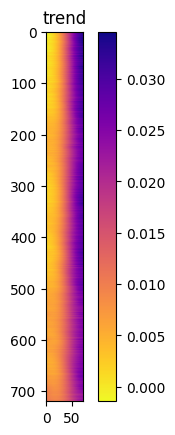

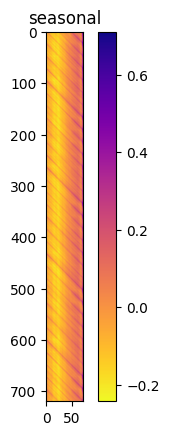

In [ ]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()

In [ ]:
display(train_df_fe)
window_size = 72
forcast_size = 720
targets = '전력사용량'
date = 'date_time'

df = train_df_fe.copy()
data_list = []
dap_list = []
date_list = []
for idx in range(0, df.shape[0]-window_size, forcast_size+1):
    x = df.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
    y = df.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
    date_ = df.loc[idx+window_size:idx+window_size+forcast_size-1,date].values

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,-1.696326,2020-06-01 00,2.747914,-1.953776,0.213861,0.765221,0.109911,-0.579503,-1.483232,-0.999995
1,-1.696326,2020-06-01 01,2.727447,-1.924448,0.472508,0.700448,-0.080867,-0.579503,-1.483232,-0.999995
2,-1.696326,2020-06-01 02,2.714005,-1.983103,0.666493,0.700448,-0.195333,-0.579503,-1.483232,-0.999995
3,-1.696326,2020-06-01 03,2.686512,-2.100414,0.666493,0.700448,-0.195333,-0.579503,-1.483232,-0.999995
4,-1.696326,2020-06-01 04,2.684068,-2.129742,0.731155,0.765221,-0.195333,-0.579503,-1.483232,-0.999995
...,...,...,...,...,...,...,...,...,...,...
97915,1.696326,2020-08-24 19,-0.334190,1.037651,0.084538,-0.789336,-0.195333,1.298607,-1.483232,-0.999995
97916,1.696326,2020-08-24 20,-0.502934,0.891012,-0.626741,-0.595016,-0.195333,-0.579503,-1.483232,-0.999995
97917,1.696326,2020-08-24 21,-0.658215,0.891012,-0.238771,-0.595016,-0.195333,-0.579503,-1.483232,-0.999995
97918,1.696326,2020-08-24 22,-0.702272,0.832357,-0.238771,-0.400696,-0.195333,-0.579503,-1.483232,-0.999995


ValueError: Cannot index with multidimensional key

In [ ]:
df

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
120718,1.704285,2020-06-15 22,0.383777,-1.453702,1.151239,0.762103,-0.196458,-0.577861,0.680951,1.035511
119412,1.646586,2020-07-16 12,-0.436787,0.248326,-0.892370,-1.042992,-0.196458,1.309688,0.680951,-0.965697
39012,-0.603687,2020-06-11 12,-0.426682,1.158031,0.887547,-1.236395,-0.196458,1.848988,-1.468519,-0.965697
25446,-1.007583,2020-07-11 06,-0.707961,-0.573343,-1.419753,0.633168,-0.196458,-0.577861,0.680951,-0.965697
4946,-1.584576,2020-07-07 02,0.447912,-0.778760,-0.694602,0.762103,-0.196458,-0.577861,0.680951,1.035511
...,...,...,...,...,...,...,...,...,...,...
109880,1.358089,2020-08-13 08,3.220801,0.805887,0.096473,0.697635,-0.196458,-0.577861,0.680951,-0.965697
41958,-0.545988,2020-07-19 06,-0.552073,-0.133163,0.162396,-0.656186,-0.196458,-0.577861,-1.468519,1.035511
87133,0.723397,2020-07-31 13,0.054043,1.304757,-0.299064,-0.333847,-0.196458,-0.577861,0.680951,1.035511
84672,0.665698,2020-07-14 00,-0.775802,-1.805846,0.162396,1.084441,2.686215,-0.577861,0.680951,1.035511


In [ ]:
train_df_fe.shape[0]

122400

In [ ]:
# 결국은 time_slide_df 함수에서 타겟값만 대상으로 뽑아낸다

,num,date_time,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_df

,num,date_time,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_df

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,-1.703413,2020-06-01 00,2.843238,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,-1.703413,2020-06-01 01,2.822152,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,-1.703413,2020-06-01 02,2.808305,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,-1.703413,2020-06-01 03,2.779980,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,-1.703413,2020-06-01 04,2.777462,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,1.703413,2020-08-24 19,0.869130,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,1.703413,2020-08-24 20,0.801780,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,1.703413,2020-08-24 21,0.605817,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,1.703413,2020-08-24 22,0.473217,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [ ]:
class moving_avg(nn.Module): # Module은 또한 다른 모듈들을 담고있다, tree구조로 품고 있다. submodule들을 특성들로 할당할 수 있다.
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride = stride, padding = 0)

    def forward(self, x):
        # time series에서 양쪽 끝에 패딩하기
        front = x[:, 0:1, :].repeat(1, (self.kernel_size-1) // 2, 1) # kernel_size : 연산을 수행할 때 윈도우의 크기를 의미
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1)) # torch.permute() 는 원하는 순서로 원본 텐서를 재정렬하고 새로운 차원으로 반환할 수 있다.
        x = x.permute(0,2,1)
        return x
    


class series_decomp(nn.Module): # nn.Module을 상속받는다는 의미 같다.
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__() # 자식 클래스가 상속받는 부모 클래스를 자식 클래스에 불러오겠다는 의미 -> 그냥 상속받는다는 의미 super().__init()__과 차이없음.
        self.moving_avg = moving_avg(kernel_size, stried=1)

    def forward(self, x): 
        moving_mean = self.moving_avg(x)
        res = x - moving_mean # 잔차 구하는거 같다.
        return res, moving_mean # 잔차와 trend 반환
    


class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs): # configs에 어떤 정보 받아져있는지 확인해볼 필요 있다.
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decomposition Kernel Size
        kernel_size = 25 # ???????????????????????????????????
        self.decomposition = series_decomp(kernel_size) # 위에 25로 설정했으니 25개의 moving avg 찍는다.
        self.individual = configs.individual # ???????????????????????
        self.channels = configs.enc_in # ????????????????????????

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    
    def forward(self, x):
        # x : [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len], dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])

        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2, 1) # to [Batch, Output length, Channel]

                



    

